In [27]:
!pip install scikit-learn


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
import time
import numpy as np
import pandas as pd
from sklearn.datasets import (
    make_blobs,
    load_iris,
    load_wine,
    load_breast_cancer,
    load_digits,
    fetch_olivetti_faces,
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt


In [29]:



def gonzalez_k_centers(X, k, rng_seed=None):
    n = X.shape[0]
    k = min(k, n)
    if k <= 0:
        return []

    rng = np.random.default_rng(rng_seed)
    centers_idx = []
    first = int(rng.integers(0, n))
    centers_idx.append(first)
    dists = np.linalg.norm(X - X[first], axis=1)  # euclidean distance
    
    for _ in range(1, k):
        idx = int(np.argmax(dists))
        centers_idx.append(idx)
        newd = np.linalg.norm(X - X[idx], axis=1)
        dists = np.minimum(dists, newd)
        
    cost= float(np.min(dists))
    return centers_idx


def k_center_cost(X, centers_idx):
    if len(centers_idx) == 0:
        return float("inf")
    centers = X[centers_idx]
    dists = np.linalg.norm(X[:, None, :] - centers[None, :, :], axis=2)
    nearest = np.min(dists, axis=1)
    return float(np.max(nearest))




In [ ]:
def hochbaum_shmoys(X, k):
    dists = pairwise_distances(X)
    n = len(dists)
    all_dists = np.unique(dists)
    all_dists = all_dists[all_dists > 0]

    low, high = 0, len(all_dists) - 1
    radius = all_dists[-1]
    final_centers = None

    while low <= high:
        mid = (low + high) // 2
        R = all_dists[mid]
        adj = []
        for i in range(n):
            neigh = np.where(dists[i] <= R)[0]
            neigh = neigh[neigh != i]
            adj.append(set(neigh))

        uncovered = set(range(n))
        centers = []

        while uncovered:
            v = next(iter(uncovered))
            centers.append(v)
            uncovered.discard(v)
            for u in adj[v]:
                uncovered.discard(u)
        

        if len(centers) <= k:
            radius = R
            final_centers = centers[:k]
            high = mid - 1
        else:
            low = mid + 1

    return final_centers, radius







Dataset: Toy Blobs

HS Cost/Radius: 0.4158
HS Time: 0.039256
HS Centers: [0, 2, 3, 6, 63, 160]
Gonzalez Cost: 0.5919
Gonzalez Time: 0.000208
Gonzalez Centers: [212, 167, 253, 185, 63, 188]

Dataset: Iris

HS Cost/Radius: 2.2121
HS Time: 0.013217
HS Centers: [0, 41, 50, 53, 117, 118]
Gonzalez Cost: 2.1222
Gonzalez Time: 0.000157
Gonzalez Centers: [42, 118, 60, 85, 15, 131]

Dataset: Wine

HS Cost/Radius: 6.0997
HS Time: 0.023523
HS Centers: [0, 59, 82, 121, 146, 158]
Gonzalez Cost: 5.8828
Gonzalez Time: 0.000217
Gonzalez Centers: [118, 121, 14, 69, 158, 115]

Dataset: Breast Cancer

HS Cost/Radius: 11.1929
HS Time: 0.299002
HS Centers: [0, 10, 68, 71, 212, 213]
Gonzalez Cost: 11.4311
Gonzalez Time: 0.000519
Gonzalez Centers: [559, 461, 152, 78, 180, 9]

Dataset: Digits

HS Cost/Radius: 30.1257
HS Time: 5.477945
HS Centers: [0, 87, 502, 988, 1070, 1264]
Gonzalez Cost: 30.8098
Gonzalez Time: 0.001448
Gonzalez Centers: [1580, 988, 502, 1264, 1070, 87]

Dataset: Olivetti Faces

HS Cost/Rad

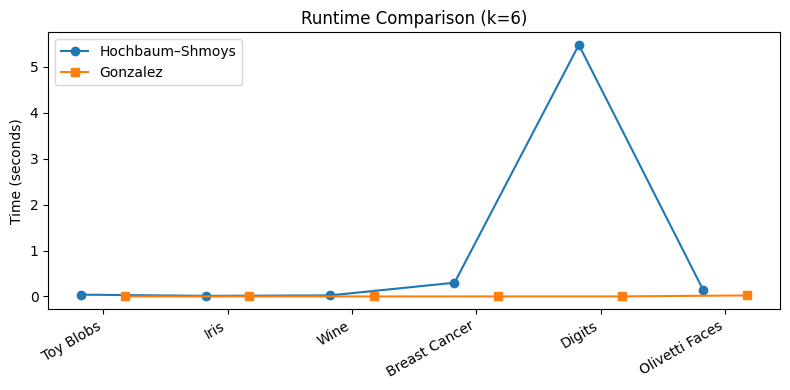

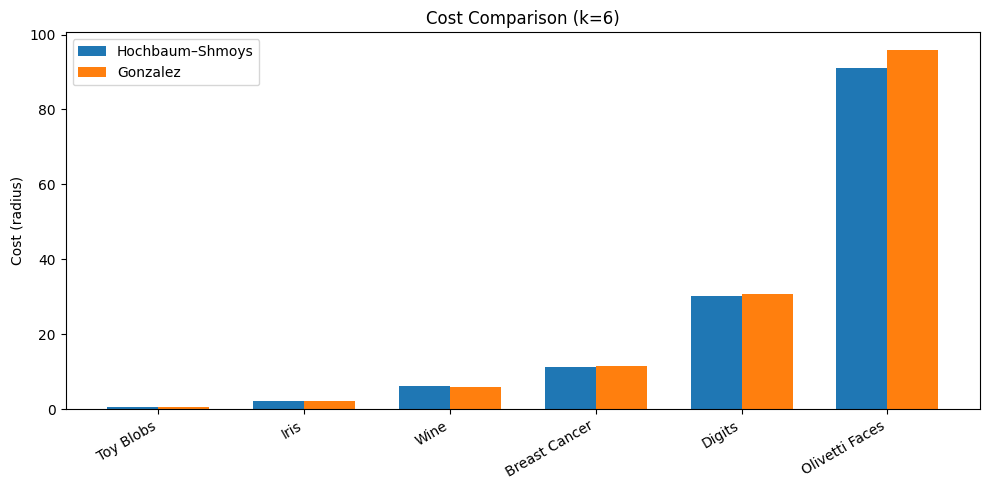

          Dataset   HS_Time  Gonzalez_Time    HS_Cost  Gonzalez_Cost
0       Toy Blobs  0.039256       0.000208   0.415840       0.591950
1            Iris  0.013217       0.000157   2.212083       2.122199
2            Wine  0.023523       0.000217   6.099717       5.882773
3   Breast Cancer  0.299002       0.000519  11.192901      11.431132
4          Digits  5.477945       0.001448  30.125652      30.809835
5  Olivetti Faces  0.141147       0.022427  91.103363      95.818153

CSV saved as: k_center_results.csv


In [31]:
hs_times = []
g_times = []
hs_costs = []
g_costs = []
dataset_names = []

def run_all(name, X, k):
    print()
    print("Dataset:", name)
    print()
    
    Xs = StandardScaler().fit_transform(X)

    t0 = time.perf_counter()
    hs_centers, hs_radius = hochbaum_shmoys(Xs, k)
    hs_time = time.perf_counter() - t0

    t1 = time.perf_counter()
    g_centers = gonzalez_k_centers(Xs, k)
    g_time = time.perf_counter() - t1
    g_cost = k_center_cost(Xs, g_centers)

    print("HS Cost/Radius:", round(hs_radius, 4))
    print("HS Time:", round(hs_time, 6))
    print("HS Centers:", hs_centers)

    print("Gonzalez Cost:", round(g_cost, 4))
    print("Gonzalez Time:", round(g_time, 6))
    print("Gonzalez Centers:", g_centers)

    hs_times.append(hs_time)
    g_times.append(g_time)
    hs_costs.append(hs_radius)
    g_costs.append(g_cost)
    dataset_names.append(name)


if __name__ == "__main__":

    datasets = []

    X_toy, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.6, random_state=42)
    datasets.append(("Toy Blobs", X_toy))

    iris = load_iris(); datasets.append(("Iris", iris.data))
    wine = load_wine(); datasets.append(("Wine", wine.data))
    breast = load_breast_cancer(); datasets.append(("Breast Cancer", breast.data))
    digits = load_digits(); datasets.append(("Digits", digits.data))

    try:
        olivetti = fetch_olivetti_faces()
        datasets.append(("Olivetti Faces", olivetti.data))
    except:
        X_syn, _ = make_blobs(n_samples=400, centers=8, cluster_std=1.2, random_state=7)
        datasets.append(("Synthetic 400", X_syn))

    k = 6

    for name, data in datasets:
        run_all(name, data, k)


    x = np.arange(len(dataset_names))
    width = 0.35

    plt.figure(figsize=(8, 4))
    plt.plot(x - width/2, hs_times, 'o-', label='Hochbaum–Shmoys')
    plt.plot(x + width/2, g_times, 's-', label='Gonzalez')

    plt.xticks(x, dataset_names, rotation=30, ha='right')
    plt.ylabel("Time (seconds)")
    plt.title(f"Runtime Comparison (k={k})")
    plt.legend()
    plt.tight_layout()
    plt.figure(figsize=(10, 5))

    bar_width = 0.35
    x = np.arange(len(dataset_names))

    plt.bar(x - bar_width/2, hs_costs, width=bar_width, label='Hochbaum–Shmoys')
    plt.bar(x + bar_width/2, g_costs, width=bar_width, label='Gonzalez')

    plt.xticks(x, dataset_names, rotation=30, ha='right')
    plt.ylabel("Cost (radius)")
    plt.title(f"Cost Comparison (k={k})")
    plt.legend()
    plt.tight_layout()


    plt.show()
    df = pd.DataFrame({
        "Dataset": dataset_names,
        "HS_Time": hs_times,
        "Gonzalez_Time": g_times,
        "HS_Cost": hs_costs,
        "Gonzalez_Cost": g_costs
    })
    print(df)

    df.to_csv("k_center_results.csv", index=False)
    print("\nCSV saved as: k_center_results.csv")
